In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = "{:.3f}".format # Only display up to three decimal places

In [2]:
UAW_staff_by_year = [pd.read_csv(f"documents/UAW LM2s/{year}_staff.csv") for year in range(2005,2024)]
UAW_officers_by_year = [pd.read_csv(f"documents/UAW LM2s/{year}_officers.csv") for year in range(2005,2024)]
Teamsters_staff_by_year = [pd.read_csv(f"documents/Teamsters LM2s/{year}_staff.csv") for year in range(2005,2024)]
Teamsters_officers_by_year = [pd.read_csv(f"documents/Teamsters LM2s/{year}_officers.csv") for year in range(2005,2024)]

In [3]:
for i in range(19):
    UAW_staff_by_year[i]['Year'] = 2005 + i
    UAW_officers_by_year[i]['Year'] = 2005 + i
    Teamsters_staff_by_year[i]['Year'] = 2005 + i
    Teamsters_officers_by_year[i]['Year'] = 2005 + i

In [4]:
UAW_staff = pd.concat(UAW_staff_by_year).reset_index()
UAW_officers = pd.concat(UAW_officers_by_year).reset_index()
Teamsters_staff = pd.concat(Teamsters_staff_by_year).reset_index()
Teamsters_officers = pd.concat(Teamsters_officers_by_year).reset_index()

In [5]:
UAW_staff['Name'] = UAW_staff['First Name'] + ' ' + UAW_staff['Last Name']
UAW_officers['Name'] = UAW_officers['First Name'] + ' ' + UAW_officers['Last Name']
Teamsters_staff['Name'] = Teamsters_staff['First Name'] + ' ' + Teamsters_staff['Last Name']
Teamsters_officers['Name'] = Teamsters_officers['First Name'] + ' ' + Teamsters_officers['Last Name']

In [6]:
# Many of the titles annoying have spaces or incosistent capitalization.
# This cell removes all non-alpha characters and converts to uppercase.
f = lambda x: ("".join([a for a in str(x) if a.isalpha()])).upper()
UAW_staff['Title'] = UAW_staff['Title'].apply(f)
UAW_officers['Title'] = UAW_officers['Title'].apply(f)
Teamsters_staff['Title'] = Teamsters_staff['Title'].apply(f)
Teamsters_officers['Title'] = Teamsters_officers['Title'].apply(f)

In [7]:
def compute_retention(df):
    retention = pd.DataFrame({'Year':df['Year'].unique()}).set_index('Year')
    for i, year in enumerate(retention.index):
        current_staff = set(df[df['Year'] == year]['Name'])
        retention.loc[year, 'Total'] = len(current_staff)
        if i > 0:
            past_staff = set(df[df['Year'] == year - 1]['Name'])
            retention.loc[year, 'Retained'] = len(past_staff.intersection(current_staff))
            retention.loc[year, 'Turnover'] = -len(past_staff.difference(current_staff))
    retention['New'] = retention['Total'] - retention['Retained']
    return retention

UAW_staff_retention = compute_retention(UAW_staff)
UAW_officers_retention = compute_retention(UAW_officers)
Teamsters_staff_retention = compute_retention(Teamsters_staff)
Teamsters_officers_retention = compute_retention(Teamsters_officers)

# Charts

In [8]:
def plot_retentions(df, title):
    df = df.iloc[1:]
    fig, ax = plt.subplots(figsize = (8,3))
    plt.stackplot(df.index, 
                  df['Turnover'],
                  colors = 'r',
                  labels = ['Turnover'],
                 alpha = 0.5)
    plt.stackplot(df.index, 
                  df[['Retained', 'New']].transpose().values,
                  colors = ['tab:blue', 'g'],
                  labels = ['Retained', 'New'],
                 alpha = 0.5)

    plt.plot(df.index, df[['Turnover', 'Retained', 'Total']].values,
            color = 'black',
            marker = '.',
            linewidth = 1,
            )
    plt.plot(df.index, [0 for _ in df.index], color = 'black')

    ax.set_xticks(range(2005, 2024))
    ax.set_xticklabels(range(2005, 2024), rotation = 45)
    ax.set_ylabel("Number of staff")
    ax.set_xlabel("Year")

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,1,0]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              loc = 'center left')
    plt.title(title, fontsize = 14)

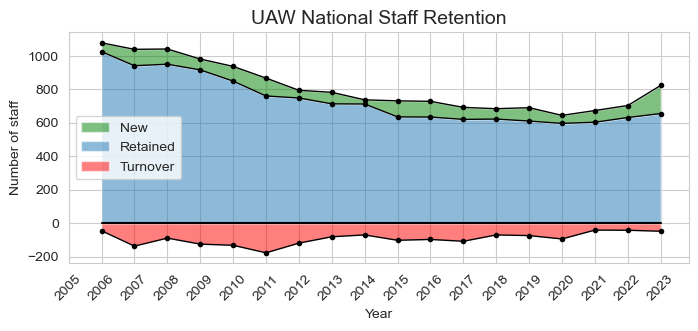

In [9]:
plot_retentions(UAW_staff_retention, "UAW National Staff Retention")

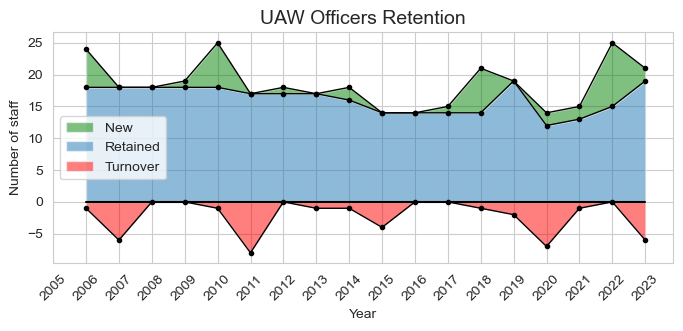

In [10]:
plot_retentions(UAW_officers_retention, "UAW Officers Retention")

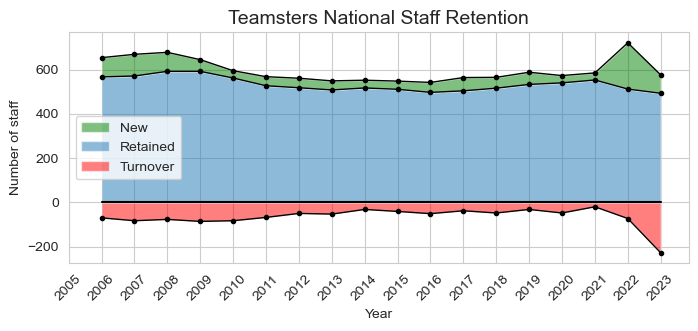

In [11]:
plot_retentions(Teamsters_staff_retention, "Teamsters National Staff Retention")

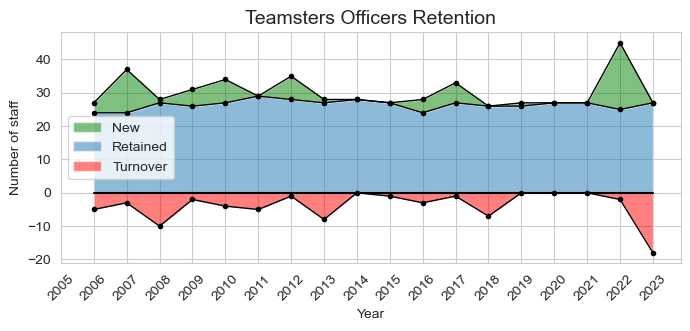

In [12]:
plot_retentions(Teamsters_officers_retention, "Teamsters Officers Retention")

# Analyzing individual staff and officer trajectories

In [13]:
def get_careers(df):
    df['Name'] = df['Name'].apply(lambda x: x.upper())
    names = df['Name'].unique()
    years = sorted(list(df['Year'].unique()))
    careers = {}
    for name in names:
        years_active = set(df[df['Name'] == name]['Year'])
        careers[name] = [1 if year in years_active else 0 for year in years]
    careers_df = pd.DataFrame.from_dict(careers, orient = 'columns')
    careers_df.index = years
    return careers_df

In [14]:
UAW_staff_careers = get_careers(UAW_staff)
UAW_officer_careers = get_careers(UAW_officers)
Teamsters_staff_careers = get_careers(Teamsters_staff)
Teamsters_officer_careers = get_careers(Teamsters_officers)

In [20]:
def plot_careers(careers_df):
    names = careers_df.columns
    first_year_active = [careers_df[name].ne(0).idxmax() for name in names]
    first_year, last_year = [careers_df.index.min(), careers_df.index.max()]
    low_end = 0.25
    high_end = 0.75
    colors = list([tuple(low_end + (high_end-low_end)*((year-first_year)/(last_year-first_year)) for _ in range(3)) for year in first_year_active])
    fig, ax = plt.subplots(figsize = (10,3))
    plt.stackplot(careers_df.index, 
                  careers_df.transpose().values,
                 colors = colors,
                  lw=0,
                  step='pre'
                 )
    ax.set_xticks(range(first_year, last_year+1))
    ax.set_xticklabels(range(first_year, last_year+1), rotation = 45)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number employed")

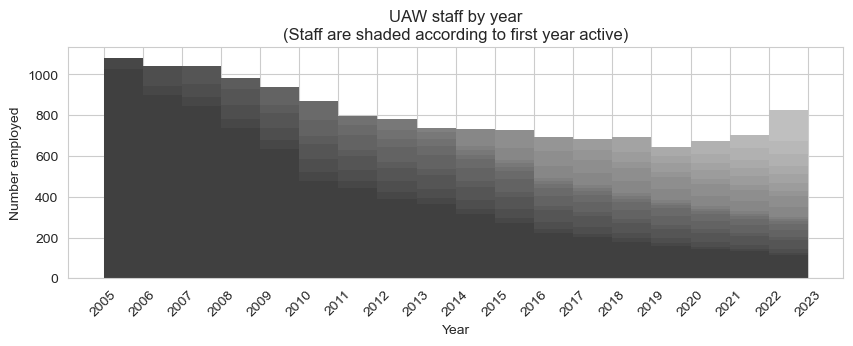

In [21]:
plot_careers(UAW_staff_careers)
plt.title("UAW staff by year\n(Staff are shaded according to first year active)")
plt.show()

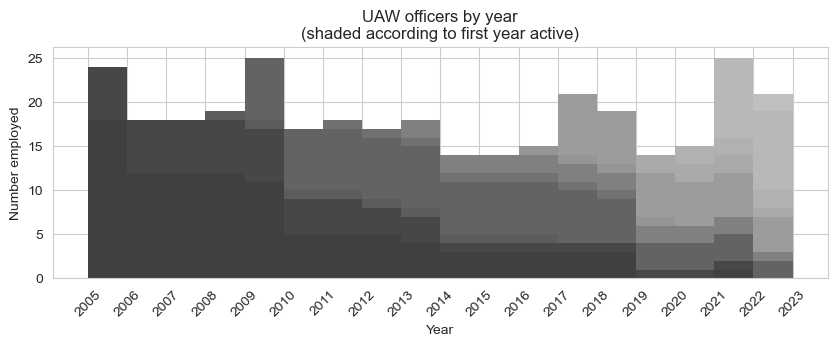

In [22]:
plot_careers(UAW_officer_careers)
plt.title("UAW officers by year\n(shaded according to first year active)")
plt.show()

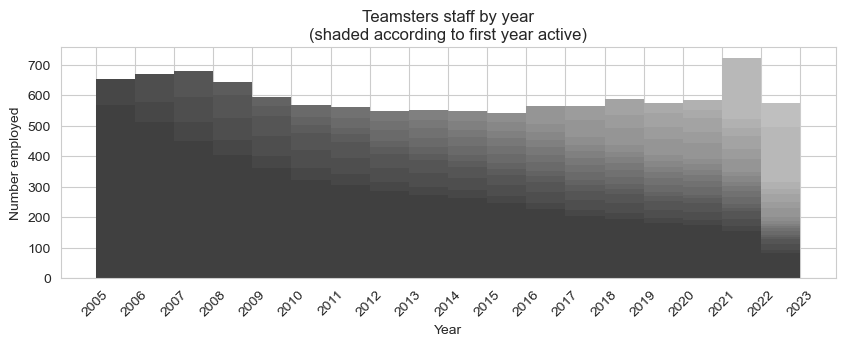

In [23]:
plot_careers(Teamsters_staff_careers)
plt.title("Teamsters staff by year\n(shaded according to first year active)")
plt.show()

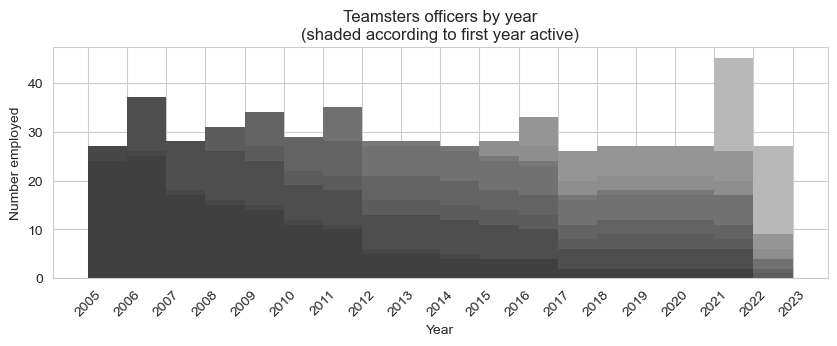

In [24]:
plot_careers(Teamsters_officer_careers)
plt.title("Teamsters officers by year\n(shaded according to first year active)")
plt.show()

In [92]:
def plot_years_worked(careers_df):
    sns.set_style('white')
    names = careers_df.columns
    first_year_active = {name:careers_df[name].ne(0).idxmax() for name in names}
    first_year, last_year = [careers_df.index.min(), careers_df.index.max()]
    
    years_worked = careers_df.copy()
    for year in careers_df.index:
        for name in names:
            years_worked.loc[year, name] = careers_df.loc[year,name]*max(0, 1+year-first_year_active[name])
    
    experience_counts_by_year = [[(years_worked.loc[year] == exp).sum() if exp != 6 else (years_worked.loc[year] >= exp).sum() for exp in [1,2,3,4,5,6]] for year in careers_df.index]
    experience_counts_by_year = pd.DataFrame(experience_counts_by_year)
    experience_counts_by_year.columns = ['0-1', '1-2', '2-3', '3-4', '4-5', '5+']
    experience_counts_by_year.index = careers_df.index
    experience_counts_by_year = experience_counts_by_year[['5+', '4-5', '3-4', '2-3','1-2','0-1']]
    experience_counts_by_year = experience_counts_by_year.iloc[5:]
    #return experience_counts_by_year
    
    tblue = (31/256, 119/256, 180/256)
    colors = [tblue + (alpha,) for alpha in [1, 0.9, 0.8, 0.7, 0.6, 0.5]]

    fig, ax = plt.subplots(figsize = (8,3))
    plt.stackplot(experience_counts_by_year.index, 
                  experience_counts_by_year.transpose().values,
                 colors = colors,
                  lw=0,
                  step='pre',
                  labels = experience_counts_by_year.columns
                 )
    ax.set_xlim(first_year+5, last_year)
    ax.set_xticks(range(first_year+5, last_year+1))
    ax.set_xticklabels(range(first_year+5, last_year+1), rotation = 45)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of staff")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
             title = 'Years worked\n as staff')

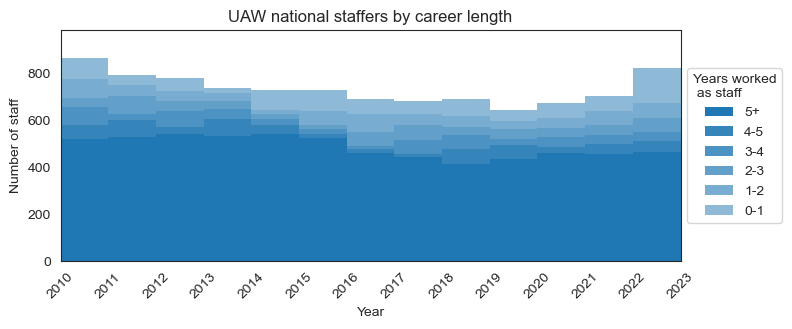

In [96]:
plot_years_worked(UAW_staff_careers)
plt.title("UAW national staffers by career length")
plt.savefig("charts/UAW_staff_careers.png", bbox_inches='tight')
plt.show()

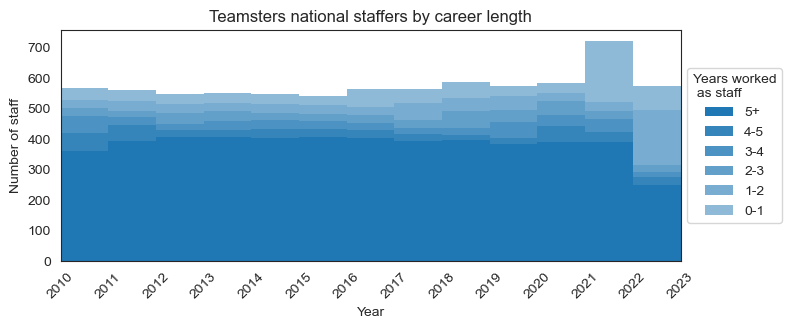

In [97]:
plot_years_worked(Teamsters_staff_careers)
plt.title("Teamsters national staffers by career length")
plt.savefig("charts/Teamsters_staff_careers.png", bbox_inches='tight')
plt.show()

# Analyze percents spent on various activities

In [25]:
activities = ['Representational Activities', 'Political Activities and Lobbying',
       'Contributions', 'General Overhead', 'Administration']

In [26]:
# Quality control: check that all staff have percents in each activity that
# add up to 100.
for df in [UAW_staff, UAW_officers, Teamsters_staff, Teamsters_officers]:
    assert list(df[activities].sum(axis = 1).unique()) == [100]

In [27]:
for activity in activities:
    UAW_staff[f"(Salary) {activity}"] = UAW_staff[activity]*UAW_staff['Salary']/100
    UAW_officers[f"(Salary) {activity}"] = UAW_officers[activity]*UAW_officers['Salary']/100
    Teamsters_staff[f"(Salary) {activity}"] = Teamsters_staff[activity]*Teamsters_staff['Salary']/100
    Teamsters_officers[f"(Salary) {activity}"] = Teamsters_officers[activity]*Teamsters_officers['Salary']/100

In [28]:
UAW_staff.groupby(by = 'Year')[[f"(Salary) {activity}" for activity in activities]].sum()

,(Salary) Representational Activities,(Salary) Political Activities and Lobbying,(Salary) Contributions,(Salary) General Overhead,(Salary) Administration
Year,,,,,
2005,82550615.340,5371896.890,86601.320,7221878.260,3166785.190
2006,82498803.740,5667625.080,33049.600,7242709.550,4949139.030
2007,81252873.290,5049360.990,549730.890,7372196.420,3004179.410
2008,82615106.660,6676498.360,593258.650,8056900.020,2649996.310
2009,78748892.690,6032194.940,577481.490,8265799.890,2525943.990
2010,64162223.260,5021823.390,9115.460,6643249.310,2602037.580
2011,66505543.870,5053962.370,0.000,6770498.070,2377636.690
2012,64246252.590,5435821.670,3084.970,5430290.230,2194230.540
2013,64981111.520,4385405.330,4122.790,5292821.940,2349012.420


In [29]:
def plot_budget_for_activities(df):
    years = sorted(df['Year'].unique())
    df = df.groupby(by = 'Year')[[f"(Salary) {activity}" for activity in activities]].sum()
    rep = df['(Salary) Representational Activities'] / 1000000
    political = df['(Salary) Political Activities and Lobbying'] / 1000000
    other = df[['(Salary) Contributions', '(Salary) General Overhead', '(Salary) Administration']].sum(axis = 1) / 1000000
    fig,ax = plt.subplots(figsize = (10,3))
    plt.stackplot(years, 
                  [other, rep, political],
                colors = ['tab:blue', 'r', 'g'],
                  alpha = 0.5,
                 labels = ['Other', 'Representation / Organizing', 'Political Activities']
                 )
    plt.stackplot(years, 
                  [other, rep, political],
                  edgecolor = 'black',
                  colors = [(0,0,0,0)]
                 )
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation = 45)
    ax.set_ylabel("Millions of dollars")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,1,0]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              loc = 'center left')

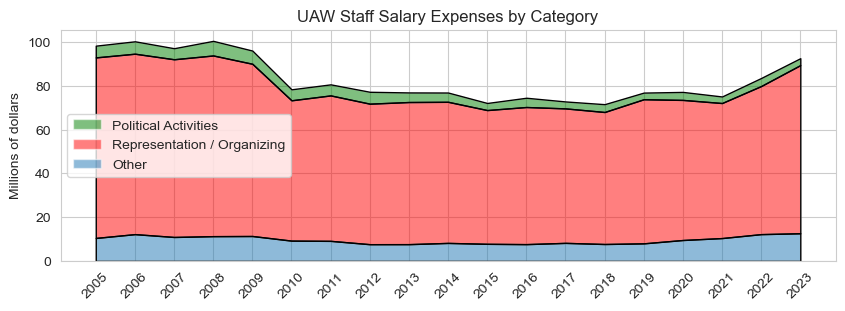

In [30]:
plot_budget_for_activities(UAW_staff)
plt.title("UAW Staff Salary Expenses by Category")
plt.show()

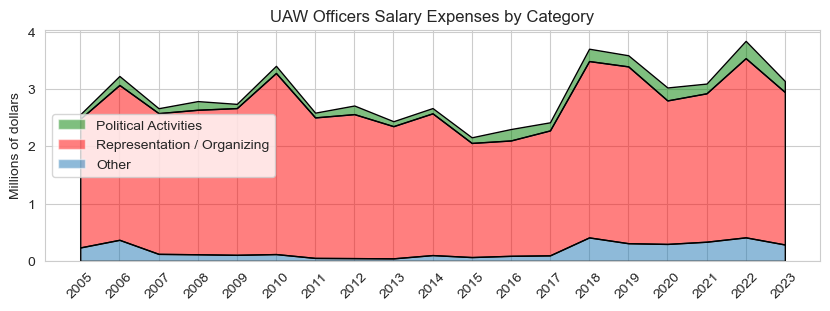

In [31]:
plot_budget_for_activities(UAW_officers)
plt.title("UAW Officers Salary Expenses by Category")
plt.show()

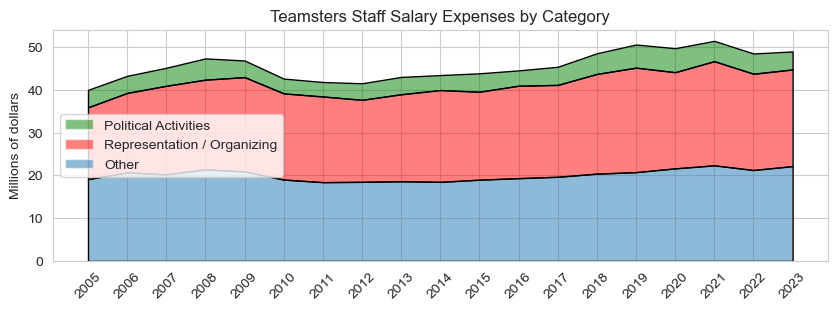

In [32]:
plot_budget_for_activities(Teamsters_staff)
plt.title("Teamsters Staff Salary Expenses by Category")
plt.show()

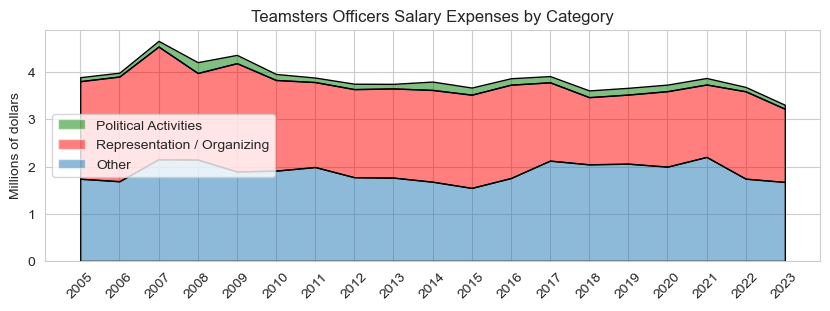

In [33]:
plot_budget_for_activities(Teamsters_officers)
plt.title("Teamsters Officers Salary Expenses by Category")
plt.show()